# Price Elasticity Models

## 1. Overview

When it comes to pricing algorithms two topics are of specific interest

**Price Elasticity of demand (PED)** 
- it gives the percentage change in quantity demanded in response to a one percent change in price. 

*In terms of economics*, elasticity is a measure of how sensitive demand or supply is to price.     
*In terms of marketing*, it is how sensitive consumers are to a change in price of a product.     
*In terms of algorithms*, in a simplest way a linear function between the log(demand) and log(price) and other additional variables. Time series forecasting (ARIMA) models and (linear) regression are common techniques to apply. 
Determining elasticity coefficients can be done at the company, brand, category, segment (price promoted group) or individual SKU level. However, the best in terms of accuracy would be the SKU level since each product behaves a little differently within a segment.

**Dynamic Pricing Algorithms (DPA)**      
DPA basically relies on pricing methods applied on traditional commercial environments where the frequency of price changes is limited. On the other hand, DPA helps to increase the quality of pricing decisions in e-commerce environments by applying sophisticated algorithms and by leverage the available big data and computing power.

*In terms of algorithms*,                 
1. In a simplest way a (linear) regression between price or log(price) and other impacting variables. 
2. The next level is to apply more complex gradient boosting frameworks (for example: LightGBM, xgboost).
3. Advanced dynamic pricing algorithms that use reinforcement learning (LSTM Recurrent Neural Networks (Python Keras, Tensorflow)) and Bayesian inference ideas (pymc3 library).

(Recurrent Neural Network is a generalization of feedforward neural network that has an internal memory. RNN is recurrent in nature as it performs the same function for every input of data while the output of the current input depends on the past one computation. In this way LSTM RNN is usable to process quite big time series inputs.)



# 2. Machine learning (ML) approach

When dealing with an ML task I usually follow the below steps.


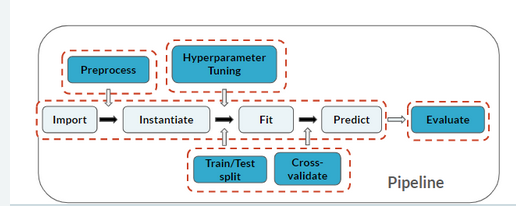

-- In this specific task, I approached the DMA topic applying LightGBM, xgboost to determine the price.     
-- From the given dataset I assumed that 'Unit Sales Total' is the amount that economists use to determine the optimal   price. Therefore 'Unit Sales Total' is the target variable in my case.
-- I applied a simplified ML process.           
-- Categorical variables were transformed to numeric ones(common technique: by applying encoders).           
-- I did experiments with scaling the features, but finally I added them in the model without scaling.             

As feature engineering:          
-- I log transformed the 'Unit Sales Total'. After transformation the target variable has became almost normal, which is good for an ML algorithm.      
-- The date variable was split in three parts: year, month, day. (usual practice, as ML algorithms need numbers as input)       
                  
-- I applied  gradient boosting frameworks LightGBM and xgboost with linear regressor. To my surprise, LightGBM performed much more better.          
-- As performance metric I used RMSE.          


# 3. Analysis

(For each step comments are added to the code)

In [69]:
import time
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

In [70]:
# define path and files to read
file = 'data/price-recommendation-trial.csv'

In [73]:
# read myfile
my_df = pd.read_csv(file,delimiter=';')
my_df = my_df.iloc[:,0:17]
my_df.head()

,Company,Channel,Brand,Subbrand,Sub Subbrand,SKU,Custom Form Value,Custom Segment Value,Custom Size Value,Date Week Ending,Dollar Sales Total,Dollar Sales Total Ya,Unit Sales Total,Unit Sales Total Ya,Volume Equivalency,Volume Sales Total,Volume Sales Total Ya
0,Manufacturer6,Channel0,Brand83,Subbrand191,Sub Subbrand212,Product659,Form 001,Segment 001,Custom Size 001,2/28/2016,81024.96077,0.0,5504.826197,0.0,30.0,163198.08900,0.0
1,Manufacturer6,Channel0,Brand83,Subbrand191,Sub Subbrand212,Product659,Form 001,Segment 001,Custom Size 001,5/8/2016,88705.97119,0.0,6111.195244,0.0,30.0,178987.97140,0.0
2,Manufacturer6,Channel0,Brand83,Subbrand191,Sub Subbrand212,Product659,Form 001,Segment 001,Custom Size 001,3/6/2016,93835.41706,0.0,6513.588901,0.0,30.0,195788.20780,0.0
3,Manufacturer6,Channel0,Brand83,Subbrand191,Sub Subbrand212,Product659,Form 001,Segment 001,Custom Size 001,5/15/2016,18050.29853,0.0,1178.727061,0.0,30.0,35613.36943,0.0
4,Manufacturer6,Channel0,Brand83,Subbrand191,Sub Subbrand212,Product659,Form 001,Segment 001,Custom Size 001,5/1/2016,64185.81172,0.0,4421.873904,0.0,30.0,135044.02900,0.0


Text(0.5, 1.0, 'Unit Sales Total Distribution')

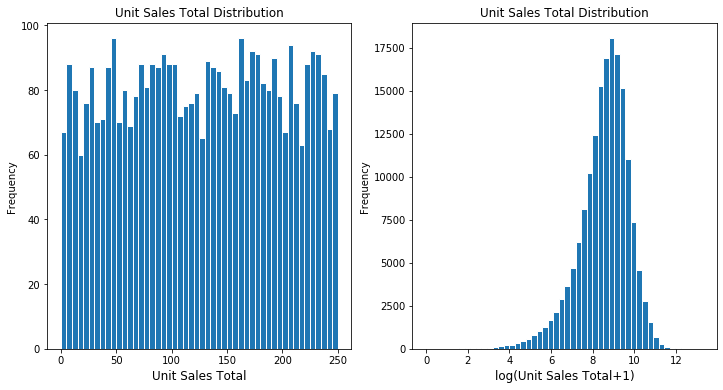

In [74]:
# Plot the distribution of 'Unit Sales Total'

plt.subplot(1, 2, 1)
(my_df['Unit Sales Total']).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('Unit Sales Total', fontsize=12)
plt.title('Unit Sales Total Distribution', fontsize=12)

plt.subplot(1, 2, 2)
np.log(my_df['Unit Sales Total']+1).plot.hist(bins=50, figsize=(12,6), edgecolor='white')
plt.xlabel('log(Unit Sales Total+1)', fontsize=12)
plt.title('Unit Sales Total Distribution', fontsize=12)

In [75]:
# Create my_df subset: loan_data_subset, skip the last column
my_df = my_df.iloc[:,0:17]

# log transform the target variable
my_df['Unit Sales Total'] = np.log(my_df['Unit Sales Total']+1)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168733 entries, 0 to 168732
Data columns (total 17 columns):
Company                  168733 non-null object
Channel                  168733 non-null object
Brand                    168733 non-null object
Subbrand                 168733 non-null object
Sub Subbrand             168733 non-null object
SKU                      168733 non-null object
Custom Form Value        168733 non-null object
Custom Segment Value     168733 non-null object
Custom Size Value        168701 non-null object
Date Week Ending         168733 non-null object
Dollar Sales Total       168733 non-null float64
Dollar Sales Total Ya    168733 non-null float64
Unit Sales Total         168733 non-null float64
Unit Sales Total Ya      168733 non-null float64
Volume Equivalency       168733 non-null float64
Volume Sales Total       168733 non-null float64
Volume Sales Total Ya    168733 non-null float64
dtypes: float64(7), object(10)
memory usage: 21.9+ MB


In [76]:
# transform objects to categorical 

def to_categorical(dataset):
    dataset['Company'] = dataset['Company'].astype('category')
    dataset['Channel'] = dataset['Channel'].astype('category')
    dataset['Brand'] = dataset['Brand'].astype('category')
    dataset['Subbrand'] = dataset['Brand'].astype('category')
    dataset['Sub Subbrand'] = dataset['Brand'].astype('category')
    dataset['SKU'] = dataset['SKU'].astype('category')

# Split date to year, month, day
my_df['Year']=pd.to_numeric(pd.to_datetime(my_df['Date Week Ending']).dt.year)
my_df['Month']=pd.to_numeric(pd.to_datetime(my_df['Date Week Ending']).dt.month)
my_df['Day']=pd.to_numeric(pd.to_datetime(my_df['Date Week Ending']).dt.day)

to_categorical(my_df)


In [77]:
# my_df.info()

In [78]:
# separate categorical and numerical columns 

# Store customerID and Churn column names
target = ['Unit Sales Total']
to_remove = ['Volume Equivalency', 'Sub Subbrand', 'Custom Form Value', 'Custom Segment Value', 'Custom Size Value', 'Year', 'Month','Day']
to_add = ['Year', 'Month','Day']

# Store categorical column names
categorical = my_df.nunique()[my_df.nunique() < 10050].keys().tolist()

# Remove target from the list of categorical variables
categorical.remove('Date Week Ending')
categorical = [x for x in categorical if x not in to_remove]
print(categorical)

# Store numerical column names
numerical = [x for x in my_df.columns if x not in to_remove + target + categorical]

numerical = numerical + to_add
numerical.remove('Date Week Ending')

print(numerical)


['Company', 'Channel', 'Brand', 'Subbrand', 'SKU']
['Dollar Sales Total', 'Dollar Sales Total Ya', 'Unit Sales Total Ya', 'Volume Sales Total', 'Volume Sales Total Ya', 'Year', 'Month', 'Day']


In [79]:
my_df = my_df[categorical+numerical+target]
my_df.columns

Index(['Company', 'Channel', 'Brand', 'Subbrand', 'SKU', 'Dollar Sales Total',
       'Dollar Sales Total Ya', 'Unit Sales Total Ya', 'Volume Sales Total',
       'Volume Sales Total Ya', 'Year', 'Month', 'Day', 'Unit Sales Total'],
      dtype='object')

In [80]:
# Perform one-hot encoding to categorical variables 
my_df_dummies = pd.get_dummies(data = my_df, columns = categorical, drop_first=True)

# Initialize StandardScaler instance
#scaler = StandardScaler()

# Fit and transform the scaler on numerical columns
#scaled_numerical = scaler.fit_transform(my_df[numerical+target])

# Build a DataFrame from scaled_numerical
#scaled_numerical = pd.DataFrame(scaled_numerical, columns=numerical+target)

# create df from dummies_categorical and numerical columns
#my_df_prep = pd.concat([my_df_dummies, scaled_numerical], axis=1)

my_df_prep = my_df_dummies

print(my_df_prep.head)

<bound method NDFrame.head of         Dollar Sales Total  Dollar Sales Total Ya  Unit Sales Total Ya  \
0             81024.960770                0.00000              0.00000   
1             88705.971190                0.00000              0.00000   
2             93835.417060                0.00000              0.00000   
3             18050.298530                0.00000              0.00000   
4             64185.811720                0.00000              0.00000   
...                    ...                    ...                  ...   
168728        27789.189060                0.00000              0.00000   
168729         8394.360922                0.00000              0.00000   
168730        24597.341400            87764.91257           4526.35751   
168731        66306.899680                0.00000              0.00000   
168732       121743.280800                0.00000              0.00000   

        Volume Sales Total  Volume Sales Total Ya  Year  Month  Day  \
0         

In [81]:
# Create the training and test sets

my_df_prep = shuffle(my_df_prep)

X = my_df_prep.drop(['Unit Sales Total'], axis=1)
y = my_df_prep[['Unit Sales Total']]

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
# Examine train, test distibutions using pairplots -- commented because of performance problems
#plt.figure()
#sns.pairplot(X_train, hue='Unit Sales Total', palette='RdBu')
#plt.show()

#plt.figure()
#sns.pairplot(X_test, hue='Unit Sales Total', palette='RdBu')
#plt.show()

In [82]:
y_train.head()

,Unit Sales Total
154011,10.235173
31312,6.334279
27583,7.650307
89042,8.536009
125634,8.251954


In [83]:
# train, predict, calculate RMSE using lightGBM
train_X = lgb.Dataset(X_train, label=y_train)

params = {
        'learning_rate': 0.75,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 100,
        'verbosity': -1,
        'metric': 'RMSE',
    }

# Fit the model on the training set
gbm = lgb.train(params, train_set=train_X, num_boost_round=3200, verbose_eval=100)

# Predict the labels of the test set: preds
preds = gbm.predict(X_test, num_iteration=gbm.best_iteration)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("The RMSE of the prediction is: %f" % (rmse))

The RMSE of the prediction is: 0.112291


In [84]:
# train, predict, calculate RMSE using xgboost

# Instantiate the XGBRegressor using linear regression
xg_reg = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=10, seed=123)


# Fit the regressor to the training set
xg_reg.fit(X_train, y_train)


# Predict the labels of the test set: preds
preds = xg_reg.predict(X_test)

# Compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("The RMSE of the prediction is: %f" % (rmse))

The RMSE of the prediction is: 2.881714


**Summary, interpreting the results**              
                      
I split the data on train and test sets (80%-20%). I traind two models one with LightGBM, the second one using xgboost linear regression.
As accuracy metrics I used RMSE (Root Mean Square Error (RMSE) (prediction errors)).  RMSE is an absolute measure of fit. Lower values of RMSE indicate better fit.

I was a little bit suprised that *LightGBM* performed much better than *xgboost*.

# 4. TO IMPROVE, NEXT STEPS

3.1 Understand better the "traditional" pricing strategies. I mean, how the analysts are doing in their daily work.       
3.2 Understand better the data.          
3.3 Deal with seasonality and special ocasions: Black Friday, Christmas time, etc      
3.4 Deal with prices granularly: product types (for example electonics, retail, etc) , brands, subbrands, customer segments, etc        
3.5 More EDA, missing value and outlier verification, feature engineering, cross-validation more metrics. 
3.6 Spend time on selecting the best models and on tunig the models' parameters
3.6 Dive into more sophisticated algorithms (deeplearning, bayes statistics).              
3.7 Advanced concepts for e-commerce.                  

I found particularly useful the following link and pdf:              

https://blog.griddynamics.com/dynamic-pricing-algorithms/             
algorithmic-marketing-ai-for-marketing-operations-r1-7g.pdf             